# Think Bayes: Chapter 2

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [4]:
from __future__ import print_function, division

% matplotlib inline

from thinkbayes2 import Hist, Pmf, Suite

import thinkplot

## The Pmf class

I'll start by making a Pmf that represents the outcome of a six-sided die.  Initially there are 6 values with equal probability.

In [5]:
pmf = Pmf()
for x in [1,2,3,4,5,6]:
    pmf[x] = 1
    
pmf.Print()

1 1
2 1
3 1
4 1
5 1
6 1


To be true probabilities, they have to add up to 1.  So we can normalize the Pmf:

In [6]:
pmf.Normalize()

6

The return value from `Normalize` is the sum of the probabilities before normalizing.

In [7]:
pmf.Print()

1 0.16666666666666666
2 0.16666666666666666
3 0.16666666666666666
4 0.16666666666666666
5 0.16666666666666666
6 0.16666666666666666


A faster way to make a Pmf is to provide a sequence of values.  The constructor adds the values to the Pmf and then normalizes:

In [8]:
pmf = Pmf([1,2,3,4,5,6])
pmf.Print()

1 0.16666666666666666
2 0.16666666666666666
3 0.16666666666666666
4 0.16666666666666666
5 0.16666666666666666
6 0.16666666666666666


To extract a value from a Pmf, you can use `Prob`

In [9]:
pmf.Prob(1)

0.16666666666666666

Or you can use the bracket operator.  Either way, if you ask for the probability of something that's not in the Pmf, the result is 0.

In [10]:
pmf[1]

0.16666666666666666

## The cookie problem

Here's a Pmf that represents the prior distribution.

In [11]:
pmf = Pmf()
pmf['Bowl 1'] = 0.5
pmf['Bowl 2'] = 0.5
pmf.Print()

Bowl 1 0.5
Bowl 2 0.5


And we can update it using `Mult`

In [12]:
pmf.Mult('Bowl 1', 0.75)
pmf.Mult('Bowl 2', 0.5)
pmf.Print()

Bowl 1 0.375
Bowl 2 0.25


Or here's the shorter way to construct the prior.

In [13]:
pmf = Pmf(['Bowl 1', 'Bowl 2'])
pmf.Print()

Bowl 1 0.5
Bowl 2 0.5


And we can use `*=` for the update.

In [14]:
pmf['Bowl 1'] *= 0.75
pmf['Bowl 2'] *= 0.5
pmf.Print()

Bowl 1 0.375
Bowl 2 0.25


Either way, we have to normalize the posterior distribution.

In [15]:
pmf.Normalize()
pmf.Print()

Bowl 1 0.6000000000000001
Bowl 2 0.4


## The Bayesian framework

Here's the same computation encapsulated in a class.

In [16]:
class Cookie(Pmf):
    """A map from string bowl ID to probablity."""

    def __init__(self, hypos):
        """Initialize self.

        hypos: sequence of string bowl IDs
        """
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, 1)
        self.Normalize()

    def Update(self, data):
        """Updates the PMF with new data.

        data: string cookie type
        """
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        self.Normalize()

    mixes = {
        'Bowl 1':dict(vanilla=0.75, chocolate=0.25),
        'Bowl 2':dict(vanilla=0.5, chocolate=0.5),
        }

    def Likelihood(self, data, hypo):
        """The likelihood of the data under the hypothesis.

        data: string cookie type
        hypo: string bowl ID
        """
        mix = self.mixes[hypo]
        like = mix[data]
        return like

We can confirm that we get the same result.

In [17]:
pmf = Cookie(['Bowl 1', 'Bowl 2'])
pmf.Update('vanilla')
pmf.Print()

Bowl 1 0.6000000000000001
Bowl 2 0.4


But this implementation is more general; it can handle any sequence of data.

In [18]:
dataset = ['vanilla', 'chocolate', 'vanilla']
for data in dataset:
    pmf.Update(data)
    
pmf.Print()

Bowl 1 0.627906976744186
Bowl 2 0.37209302325581395


## The Monty Hall problem

The Monty Hall problem might be the most contentious question in
the history of probability.  The scenario is simple, but the correct
answer is so counterintuitive that many people just can't accept
it, and many smart people have embarrassed themselves not just by
getting it wrong but by arguing the wrong side, aggressively,
in public.

Monty Hall was the original host of the game show *Let's Make a
Deal*.  The Monty Hall problem is based on one of the regular
games on the show.  If you are on the show, here's what happens:

*  Monty shows you three closed doors and tells you that there is a
   prize behind each door: one prize is a car, the other two are less
   valuable prizes like peanut butter and fake finger nails.  The
   prizes are arranged at random.

*  The object of the game is to guess which door has the car.  If
   you guess right, you get to keep the car.

*  You pick a door, which we will call Door A.  We'll call the
   other doors B and C.

*  Before opening the door you chose, Monty increases the
   suspense by opening either Door B or C, whichever does not
   have the car.  (If the car is actually behind Door A, Monty can
   safely open B or C, so he chooses one at random.)

*  Then Monty offers you the option to stick with your original
   choice or switch to the one remaining unopened door.

The question is, should you "stick" or "switch" or does it
make no difference?

Most people have the strong intuition that it makes no difference.
There are two doors left, they reason, so the chance that the car
is behind Door A is 50%.

But that is wrong.  In fact, the chance of winning if you stick
with Door A is only 1/3; if you switch, your chances are 2/3.

Here's a class that solves the Monty Hall problem.

In [19]:
class Monty(Pmf):
    """Map from string location of car to probability"""

    def __init__(self, hypos):
        """Initialize the distribution.

        hypos: sequence of hypotheses
        """
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, 1)
        self.Normalize()

    def Update(self, data):
        """Updates each hypothesis based on the data.

        data: any representation of the data
        """
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        self.Normalize()

    def Likelihood(self, data, hypo):
        """Compute the likelihood of the data under the hypothesis.

        hypo: string name of the door where the prize is
        data: string name of the door Monty opened
        """
        if hypo == data:
            return 0
        elif hypo == 'A':
            return 0.5
        else:
            return 1

And here's how we use it.

In [20]:
pmf = Monty('ABC')
pmf.Update('B')
pmf.Print()

A 0.3333333333333333
B 0.0
C 0.6666666666666666


## The Suite class

Most Bayesian updates look pretty much the same, especially the `Update` method.  So we can encapsulate the framework in a class, `Suite`, and create new classes that extend it.

Child classes of `Suite` inherit `Update` and provide `Likelihood`.  So here's the short version of `Monty`

In [21]:
class Monty(Suite):

    def Likelihood(self, data, hypo):
        if hypo == data:
            return 0
        elif hypo == 'A':
            return 0.5
        else:
            return 1

And it works.

In [22]:
pmf = Monty('ABC')
pmf.Update('B')
pmf.Print()

A 0.3333333333333333
B 0.0
C 0.6666666666666666


## The M&M problem

M&Ms are small candy-coated chocolates that come in a variety of
colors.  Mars, Inc., which makes M&Ms, changes the mixture of
colors from time to time.

In 1995, they introduced blue M&Ms.  Before then, the color mix in
a bag of plain M&Ms was 30% Brown, 20% Yellow, 20% Red, 10%
Green, 10% Orange, 10% Tan.  Afterward it was 24% Blue , 20%
Green, 16% Orange, 14% Yellow, 13% Red, 13% Brown.

Suppose a friend of mine has two bags of M&Ms, and he tells me
that one is from 1994 and one from 1996.  He won't tell me which is
which, but he gives me one M&M from each bag.  One is yellow and
one is green.  What is the probability that the yellow one came
from the 1994 bag?

Here's a solution:

In [23]:
class M_and_M(Suite):
    """Map from hypothesis (A or B) to probability."""

    mix94 = dict(brown=30,
                 yellow=20,
                 red=20,
                 green=10,
                 orange=10,
                 tan=10,
                 blue=0)

    mix96 = dict(blue=24,
                 green=20,
                 orange=16,
                 yellow=14,
                 red=13,
                 brown=13,
                 tan=0)

    hypoA = dict(bag1=mix94, bag2=mix96)
    hypoB = dict(bag1=mix96, bag2=mix94)

    hypotheses = dict(A=hypoA, B=hypoB)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: string hypothesis (A or B)
        data: tuple of string bag, string color
        """
        bag, color = data
        mix = self.hypotheses[hypo][bag]
        like = mix[color]
        return like

And here's an update:

In [24]:
suite = M_and_M('AB')
suite.Update(('bag1', 'yellow'))
suite.Update(('bag2', 'green'))
suite.Print()

A 0.7407407407407407
B 0.2592592592592592


**Exercise:**  Suppose you draw another M&M from `bag1` and it's blue.  What can you conclude?  Run the update to confirm your intuition.

In [25]:
suite.Update(('bag1', 'blue'))
suite.Print()

A 0.0
B 1.0


**Exercise:**  Now suppose you draw an M&M from `bag2` and it's blue.  What does that mean?  Run the update to see what happens.

In [26]:
# Solution goes here
suite.Update(('bag2', 'blue'))
suite.Print()

# This is impossible, because there can't be blue in both.

ValueError: Normalize: total probability is zero.

## Exercises

**Exercise:** This one is from one of my favorite books, David MacKay's "Information Theory, Inference, and Learning Algorithms":

> Elvis Presley had a twin brother who died at birth.  What is the probability that Elvis was an identical twin?"
    
To answer this one, you need some background information: According to the Wikipedia article on twins:  ``Twins are estimated to be approximately 1.9% of the world population, with monozygotic twins making up 0.2% of the total---and 8% of all twins.''

In [ ]:
pmf = Pmf(dict(mz=8, dz=92))
pmf['mz'] *= 1
pmf['dz'] *= 0.5
pmf.Normalize()
pmf.Print()

In [ ]:
# Solution goes here

**Exercise:** Let's consider a more general version of the Monty Hall problem where Monty is more unpredictable.  As before, Monty never opens the door you chose (let's call it A) and never opens the door with the prize.  So if you choose the door with the prize, Monty has to decide which door to open.  Suppose he opens B with probability `p` and C with probability `1-p`.  If you choose A and Monty opens B, what is the probability that the car is behind A, in terms of `p`?  What if Monty opens C?

Hint: you might want to use SymPy to do the algebra for you. 

In [ ]:
from sympy import symbols
p = symbols('p')

from thinkbayes2 import Suite

class MontySuite(Suite):
    def Likelihood(self, data, hypo):
        if hypo == data:
            return 0
        elif hypo == 'A':
            return p
        else:
            return 1

suite = MontySuite('ABC')
suite.Update('B')
suite.Print()

In [ ]:
# Solution goes here
suite['A'].simplify()


In [ ]:
# Solution goes here
suite['A'].evalf(subs=dict(p=0.5))

# or
suite['A'].subs(p, 0.5)

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

**Exercise:** According to the CDC, ``Compared to nonsmokers, men who smoke are about 23 times more likely to develop lung cancer and women who smoke are about 13 times more likely.''  Also, among adults in the U.S. in 2014:

> Nearly 19 of every 100 adult men (18.8%)
> Nearly 15 of every 100 adult women (14.8%)

If you learn that a woman has been diagnosed with lung cancer, and you know nothing else about her, what is the probability that she is a smoker?

In [ ]:
# Solution goes here


**Exercise** In Section 2.3 I said that the solution to the cookie problem generalizes to the case where we draw multiple cookies with replacement.

But in the more likely scenario where we eat the cookies we draw, the likelihood of each draw depends on the previous draws.

Modify the solution in this chapter to handle selection without replacement. Hint: add instance variables to Cookie to represent the hypothetical state of the bowls, and modify Likelihood accordingly. You might want to define a Bowl object.

In [28]:
# Solution goes here
from scipy.special import binom
import scipy.stats as stats

In [60]:
# Solution goes here
binom(52, 5) # how many combinations of 5 cards are there (from a deck of 52 cards)

2598960.0

In [30]:
# Solution goes here
#3 blues out of 5, from an urn that is 2/3s blue
stats.binom.pmf(3, 5, 2/3)

#QUIZ! 3 choose 5 with 2/3s for each prob

0.32921810699588472

In [61]:
# Solution goes here

# the hypergeometric
# N: # marbles in the urn
# K: # marbles considered "success"
# n: number selected
# k: number of "successes"

#P(k successes in n trials (without replacement)) = PMF_hypergeom(k; N, K, n)

# creates a function of k given the params (N, K, n)
help(stats.hypergeom.pmf)

Help on method pmf in module scipy.stats._distn_infrastructure:

pmf(k, *args, **kwds) method of scipy.stats._discrete_distns.hypergeom_gen instance
    Probability mass function at k of the given RV.
    
    Parameters
    ----------
    k : array_like
        Quantiles.
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        Location parameter (default=0).
    
    Returns
    -------
    pmf : array_like
        Probability mass function evaluated at k



$P(X = k) = \frac{\binom{K}{k} \binom{N - K}{n-k}}{\binom{N}{n}}$

* $N$ is the population size,
* $K$ is the number of success states in the population,
* $n$ is the number of draws,
* $k$ is the number of observed successes,
* $\textstyle {a \choose b}$ is a binomial coefficient.

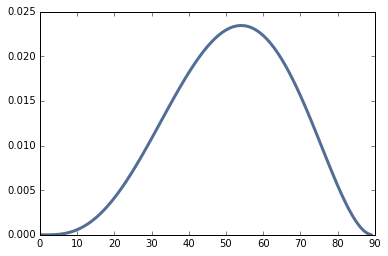

In [58]:
# Solution goes here

N = 90 # population size
K = 60 # number of success states in the population 
n = 5 # number of draws
k = 3 # number of observed successes

pmf = lambda K: binom(K, k) * binom(N - K, n - k) / binom(N, n)

it = Pmf({K: pmf(K) for K in range(90)})

it.Normalize()

thinkplot.Pdf(it)

In [59]:
# Solution goes here

stats.hypergeom.pmf(k, N, K, n)

0.3387018869119775

In [ ]:
# Solution goes here